In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, f_oneway
import warnings
import os

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Ensure output directories exist
os.makedirs('../results', exist_ok=True)

# Load the data
df = pd.read_csv(r'C:\Users\admin\insurance-risk-analysis-week3\data\raw\insurance_data.csv')
print(f"Data loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nColumns:\n{df.columns.tolist()}")
print("\nFirst 5 rows:")
print(df.head())


Data loaded: 5000 rows, 18 columns

Columns:
['PolicyID', 'TransactionMonth', 'Province', 'VehicleType', 'Gender', 'Make', 'Model', 'TotalPremium', 'TotalClaims', 'CustomValueEstimate', 'SumInsured', 'CalculatedPremiumPerTerm', 'CoverType', 'RegistrationYear', 'NumberOfDoors', 'Bodytype', 'MaritalStatus', 'LossRatio']

First 5 rows:
   PolicyID TransactionMonth       Province VehicleType  Gender      Make  \
0    100000       2014-02-01   Western Cape       Sedan    Male      Ford   
1    100001       2014-02-02        Limpopo         SUV    Male  Mercedes   
2    100002       2014-02-03     Free State  Motorcycle    Male      Ford   
3    100003       2014-02-04  KwaZulu-Natal       Sedan  Female    Toyota   
4    100004       2014-02-05        Gauteng  Motorcycle    Male    Toyota   

      Model  TotalPremium  TotalClaims  CustomValueEstimate     SumInsured  \
0   Qashqai   2325.410068          0.0         48813.579464   89755.123392   
1      Golf   4229.846331          0.0        

In [3]:
# Data Preparation: Calculate required metrics
print("Calculating risk metrics...")

# Create binary claim indicator
df['has_claim'] = (df['TotalClaims'] > 0).astype(int)

# Calculate claim severity (average claim when claim occurs)
df['claim_severity'] = df.apply(lambda x: x['TotalClaims'] if x['TotalClaims'] > 0 else np.nan, axis=1)

# Calculate margin
df['margin'] = df['TotalPremium'] - df['TotalClaims']

# Calculate loss ratio
df['loss_ratio'] = df['TotalClaims'] / df['TotalPremium']
df['loss_ratio'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Basic statistics
print(f"\nOverall Statistics:")
print(f"Total Policies: {len(df):,}")
print(f"Policies with Claims: {df['has_claim'].sum():,} ({df['has_claim'].mean()*100:.1f}%)")
print(f"Average Claim Amount (when claim occurs): R{df['claim_severity'].mean():.2f}")
print(f"Average Premium: R{df['TotalPremium'].mean():.2f}")
print(f"Average Margin: R{df['margin'].mean():.2f}")
print(f"Average Loss Ratio: {df['loss_ratio'].mean():.4f}")

Calculating risk metrics...

Overall Statistics:
Total Policies: 5,000
Policies with Claims: 1,479 (29.6%)
Average Claim Amount (when claim occurs): R2112.00
Average Premium: R6705.36
Average Margin: R6080.63
Average Loss Ratio: 0.1810


In [4]:
# HYPOTHESIS 1: Risk Differences Across Provinces
print("="*70)
print("HYPOTHESIS 1: Risk Differences Across Provinces")
print("="*70)

# Check available provinces
provinces = df['Province'].unique()
print(f"\nNumber of provinces: {len(provinces)}")
print(f"Provinces: {provinces}")


HYPOTHESIS 1: Risk Differences Across Provinces

Number of provinces: 9
Provinces: ['Western Cape' 'Limpopo' 'Free State' 'KwaZulu-Natal' 'Gauteng'
 'Mpumalanga' 'Eastern Cape' 'Northern Cape' 'North West']


In [5]:
# Calculate metrics by province
province_stats = df.groupby('Province').agg({
    'has_claim': ['count', 'mean', 'sum'],
    'claim_severity': 'mean',
    'TotalPremium': 'mean',
    'TotalClaims': 'mean',
    'margin': 'mean',
    'loss_ratio': 'mean'
}).round(4)

# Rename columns for clarity
province_stats.columns = ['policy_count', 'claim_freq', 'claim_count', 
                         'avg_severity', 'avg_premium', 'avg_claims',
                         'avg_margin', 'avg_loss_ratio']

# Sort by claim frequency
province_stats = province_stats.sort_values('claim_freq', ascending=False)

print("\nProvince Statistics:")
print(province_stats)



Province Statistics:
               policy_count  claim_freq  claim_count  avg_severity  \
Province                                                             
Northern Cape           202      0.3218           65     2921.6148   
Mpumalanga              302      0.3179           96     1822.5970   
Limpopo                 226      0.3142           71     1918.7859   
Western Cape            994      0.3038          302     2126.5445   
North West              364      0.2995          109     2076.0142   
Gauteng                1283      0.2962          380     2114.0819   
Eastern Cape            531      0.2919          155     1899.3365   
KwaZulu-Natal           722      0.2770          200     2286.2972   
Free State              376      0.2686          101     1970.6378   

               avg_premium  avg_claims  avg_margin  avg_loss_ratio  
Province                                                            
Northern Cape    6249.4843    940.1236   5309.3607          0.2784  


In [6]:
# Statistical Test 1: ANOVA for claim severity across provinces
print("\nStatistical Test 1: ANOVA for Claim Severity")

# Prepare data for ANOVA
province_groups = []
for province in province_stats.index:
    province_data = df[df['Province'] == province]['claim_severity'].dropna()
    if len(province_data) > 0:
        province_groups.append(province_data)

# Perform ANOVA
if len(province_groups) >= 2:
    f_stat, p_value_severity = f_oneway(*province_groups)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {p_value_severity:.6f}")
    
    alpha = 0.05
    if p_value_severity < alpha:
        print(f"Result: REJECT null hypothesis (p < {alpha})")
        print("Interpretation: There are significant differences in claim severity across provinces")
    else:
        print(f"Result: FAIL TO REJECT null hypothesis (p >= {alpha})")
        print("Interpretation: No significant differences in claim severity across provinces")


Statistical Test 1: ANOVA for Claim Severity
F-statistic: 0.7952
p-value: 0.606898
Result: FAIL TO REJECT null hypothesis (p >= 0.05)
Interpretation: No significant differences in claim severity across provinces


In [7]:
# Statistical Test 2: Chi-square test for claim frequency
print("\nStatistical Test 2: Chi-square for Claim Frequency")

# Create contingency table
contingency_table = pd.crosstab(df['Province'], df['has_claim'])
print("Contingency Table:")
print(contingency_table)

# Perform chi-square test
chi2, p_value_frequency, dof, expected = chi2_contingency(contingency_table)
print(f"\nChi-square statistic: {chi2:.4f}")
print(f"Degrees of freedom: {dof}")
print(f"p-value: {p_value_frequency:.6f}")

alpha = 0.05
if p_value_frequency < alpha:
    print(f"Result: REJECT null hypothesis (p < {alpha})")
    print("Interpretation: There are significant differences in claim frequency across provinces")
else:
    print(f"Result: FAIL TO REJECT null hypothesis (p >= {alpha})")
    print("Interpretation: No significant differences in claim frequency across provinces")


Statistical Test 2: Chi-square for Claim Frequency
Contingency Table:
has_claim        0    1
Province               
Eastern Cape   376  155
Free State     275  101
Gauteng        903  380
KwaZulu-Natal  522  200
Limpopo        155   71
Mpumalanga     206   96
North West     255  109
Northern Cape  137   65
Western Cape   692  302

Chi-square statistic: 4.6551
Degrees of freedom: 8
p-value: 0.793726
Result: FAIL TO REJECT null hypothesis (p >= 0.05)
Interpretation: No significant differences in claim frequency across provinces


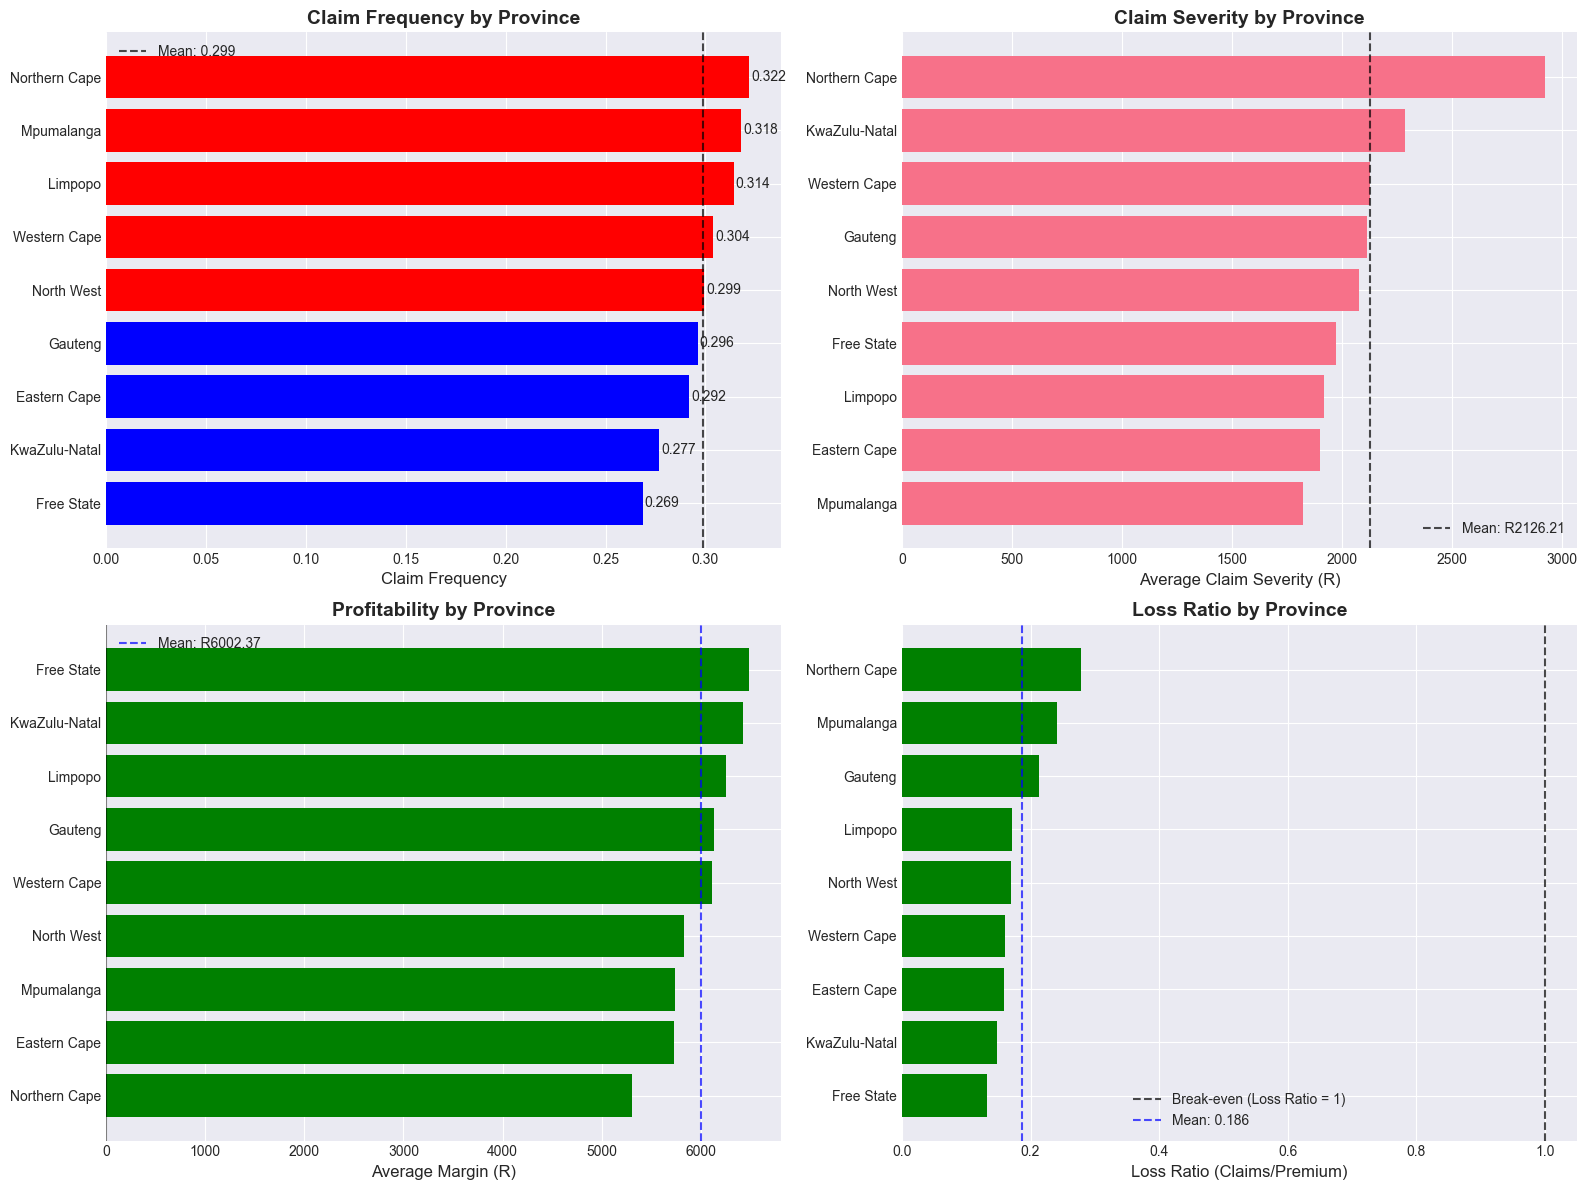

In [8]:
# Visualization: Province Risk Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Claim Frequency by Province
ax1 = axes[0, 0]
province_freq = province_stats['claim_freq'].sort_values(ascending=True)
colors = ['red' if x > province_stats['claim_freq'].mean() else 'blue' for x in province_freq]
bars = ax1.barh(range(len(province_freq)), province_freq.values, color=colors)
ax1.set_yticks(range(len(province_freq)))
ax1.set_yticklabels(province_freq.index)
ax1.set_xlabel('Claim Frequency', fontsize=12)
ax1.set_title('Claim Frequency by Province', fontsize=14, fontweight='bold')
ax1.axvline(x=province_stats['claim_freq'].mean(), color='black', linestyle='--', 
            alpha=0.7, label=f'Mean: {province_stats["claim_freq"].mean():.3f}')
ax1.legend()

for i, (bar, freq) in enumerate(zip(bars, province_freq.values)):
    ax1.text(freq + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{freq:.3f}', va='center', fontsize=10)

# Plot 2: Claim Severity by Province
ax2 = axes[0, 1]
province_severity = province_stats['avg_severity'].sort_values(ascending=True)
bars2 = ax2.barh(range(len(province_severity)), province_severity.values)
ax2.set_yticks(range(len(province_severity)))
ax2.set_yticklabels(province_severity.index)
ax2.set_xlabel('Average Claim Severity (R)', fontsize=12)
ax2.set_title('Claim Severity by Province', fontsize=14, fontweight='bold')
ax2.axvline(x=province_stats['avg_severity'].mean(), color='black', 
            linestyle='--', alpha=0.7, label=f'Mean: R{province_stats["avg_severity"].mean():.2f}')
ax2.legend()

# Plot 3: Margin by Province
ax3 = axes[1, 0]
province_margin = province_stats['avg_margin'].sort_values(ascending=True)
colors_margin = ['green' if x > 0 else 'red' for x in province_margin]
bars3 = ax3.barh(range(len(province_margin)), province_margin.values, color=colors_margin)
ax3.set_yticks(range(len(province_margin)))
ax3.set_yticklabels(province_margin.index)
ax3.set_xlabel('Average Margin (R)', fontsize=12)
ax3.set_title('Profitability by Province', fontsize=14, fontweight='bold')
ax3.axvline(x=0, color='black', linestyle='-', alpha=0.5)
ax3.axvline(x=province_stats['avg_margin'].mean(), color='blue', 
            linestyle='--', alpha=0.7, label=f'Mean: R{province_stats["avg_margin"].mean():.2f}')
ax3.legend()

# Plot 4: Loss Ratio by Province
ax4 = axes[1, 1]
province_loss = province_stats['avg_loss_ratio'].sort_values(ascending=True)
colors_loss = ['red' if x > 1 else 'green' for x in province_loss]
bars4 = ax4.barh(range(len(province_loss)), province_loss.values, color=colors_loss)
ax4.set_yticks(range(len(province_loss)))
ax4.set_yticklabels(province_loss.index)
ax4.set_xlabel('Loss Ratio (Claims/Premium)', fontsize=12)
ax4.set_title('Loss Ratio by Province', fontsize=14, fontweight='bold')
ax4.axvline(x=1, color='black', linestyle='--', alpha=0.7, label='Break-even (Loss Ratio = 1)')
ax4.axvline(x=province_stats['avg_loss_ratio'].mean(), color='blue', 
            linestyle='--', alpha=0.7, label=f'Mean: {province_stats["avg_loss_ratio"].mean():.3f}')
ax4.legend()

plt.tight_layout()
plt.savefig('../results/province_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Business Interpretation for Hypothesis 1
print("="*70)
print("BUSINESS INTERPRETATION FOR HYPOTHESIS 1")
print("="*70)

# Identify highest and lowest risk provinces
highest_risk = province_stats['claim_freq'].idxmax()
lowest_risk = province_stats['claim_freq'].idxmin()
risk_difference = (province_stats.loc[highest_risk, 'claim_freq'] - 
                   province_stats.loc[lowest_risk, 'claim_freq']) * 100

# Identify most and least profitable provinces
most_profitable = province_stats['avg_margin'].idxmax()
least_profitable = province_stats['avg_margin'].idxmin()
profit_difference = province_stats.loc[most_profitable, 'avg_margin'] - province_stats.loc[least_profitable, 'avg_margin']

print(f"\nKey Findings:")
print(f"1. Highest Claim Frequency: {highest_risk} ({province_stats.loc[highest_risk, 'claim_freq']*100:.1f}%)")
print(f"   Lowest Claim Frequency: {lowest_risk} ({province_stats.loc[lowest_risk, 'claim_freq']*100:.1f}%)")
print(f"   Difference: {risk_difference:.1f} percentage points")

print(f"\n2. Most Profitable: {most_profitable} (R{province_stats.loc[most_profitable, 'avg_margin']:.2f} margin per policy)")
print(f"   Least Profitable: {least_profitable} (R{province_stats.loc[least_profitable, 'avg_margin']:.2f} margin per policy)")
print(f"   Difference: R{profit_difference:.2f} per policy")

print(f"\n3. Loss Ratio Analysis:")
for province in province_stats.index:
    loss_ratio = province_stats.loc[province, 'avg_loss_ratio']
    if loss_ratio > 1.0:
        print(f"   • {province}: Loss Ratio = {loss_ratio:.3f} (UNPROFITABLE)")
    elif loss_ratio > 0.8:
        print(f"   • {province}: Loss Ratio = {loss_ratio:.3f} (MARGINAL)")
    else:
        print(f"   • {province}: Loss Ratio = {loss_ratio:.3f} (PROFITABLE)")

print(f"\nBusiness Recommendations:")
print(f"1. Implement regional premium adjustments based on risk levels")
print(f"2. Increase premiums in {highest_risk} by {risk_difference/2:.1f}% to account for higher risk")
print(f"3. Review underwriting criteria in {least_profitable} to improve profitability")
print(f"4. Consider geographic risk segmentation in pricing models")
print(f"5. Monitor {province_stats[province_stats['avg_loss_ratio'] > 0.9].index.tolist()} closely for loss ratio trends")


BUSINESS INTERPRETATION FOR HYPOTHESIS 1

Key Findings:
1. Highest Claim Frequency: Northern Cape (32.2%)
   Lowest Claim Frequency: Free State (26.9%)
   Difference: 5.3 percentage points

2. Most Profitable: Free State (R6486.74 margin per policy)
   Least Profitable: Northern Cape (R5309.36 margin per policy)
   Difference: R1177.38 per policy

3. Loss Ratio Analysis:
   • Northern Cape: Loss Ratio = 0.278 (PROFITABLE)
   • Mpumalanga: Loss Ratio = 0.241 (PROFITABLE)
   • Limpopo: Loss Ratio = 0.172 (PROFITABLE)
   • Western Cape: Loss Ratio = 0.161 (PROFITABLE)
   • North West: Loss Ratio = 0.170 (PROFITABLE)
   • Gauteng: Loss Ratio = 0.214 (PROFITABLE)
   • Eastern Cape: Loss Ratio = 0.159 (PROFITABLE)
   • KwaZulu-Natal: Loss Ratio = 0.148 (PROFITABLE)
   • Free State: Loss Ratio = 0.132 (PROFITABLE)

Business Recommendations:
1. Implement regional premium adjustments based on risk levels
2. Increase premiums in Northern Cape by 2.7% to account for higher risk
3. Review underwri

In [10]:

# HYPOTHESIS 2: Risk Differences Between Zip Codes (Using Make as Proxy)
print("="*70)
print("HYPOTHESIS 2: Risk Differences Between Zip Codes (Using Make as Proxy)")
print("="*70)

# Get top 10 makes for analysis
top_makes = df['Make'].value_counts().nlargest(10).index.tolist()
print(f"\nTop 10 Vehicle Makes (Proxy for Zip Code areas):")
for i, make in enumerate(top_makes, 1):
    count = df[df['Make'] == make].shape[0]
    print(f"  {i}. {make}: {count:,} policies ({count/len(df)*100:.1f}%)")

# Select top 2 makes for A/B testing
make_a, make_b = top_makes[:2]

print(f"\nA/B Testing Setup:")
print(f"Group A (Control): {make_a}")
print(f"Group B (Test): {make_b}")

# Create groups
group_a = df[df['Make'] == make_a].copy()
group_b = df[df['Make'] == make_b].copy()

print(f"\nGroup Statistics:")
print(f"Group A ({make_a}): {len(group_a):,} policies")
print(f"Group B ({make_b}): {len(group_b):,} policies")

HYPOTHESIS 2: Risk Differences Between Zip Codes (Using Make as Proxy)

Top 10 Vehicle Makes (Proxy for Zip Code areas):
  1. Toyota: 1,197 policies (23.9%)
  2. Volkswagen: 974 policies (19.5%)
  3. Ford: 770 policies (15.4%)
  4. Mercedes: 545 policies (10.9%)
  5. BMW: 512 policies (10.2%)
  6. Nissan: 373 policies (7.5%)
  7. Hyundai: 368 policies (7.4%)
  8. Kia: 261 policies (5.2%)

A/B Testing Setup:
Group A (Control): Toyota
Group B (Test): Volkswagen

Group Statistics:
Group A (Toyota): 1,197 policies
Group B (Volkswagen): 974 policies


In [11]:
# Check balance on key variables
print(f"\nBalance Check (p-values for differences in key variables):")

balance_tests = []
for variable in ['VehicleType', 'Gender', 'TotalPremium', 'RegistrationYear']:
    if variable in df.columns:
        data_a = group_a[variable].fillna(group_a[variable].median() if group_a[variable].dtype in ['int64', 'float64'] else group_a[variable].mode()[0])
        data_b = group_b[variable].fillna(group_b[variable].median() if group_b[variable].dtype in ['int64', 'float64'] else group_b[variable].mode()[0])
        
        if data_a.dtype in ['int64', 'float64']:
            t_stat, p_val = ttest_ind(data_a, data_b, equal_var=False)
            test_type = "T-test"
        else:
            cont_table = pd.crosstab(
                pd.concat([data_a, data_b]),
                ['A']*len(data_a) + ['B']*len(data_b)
            )
            chi2, p_val, dof, expected = chi2_contingency(cont_table)
            test_type = "Chi-square"
        
        balance_tests.append({
            'Variable': variable,
            'Test': test_type,
            'p-value': p_val,
            'Balanced': p_val > 0.05
        })

balance_df = pd.DataFrame(balance_tests)
print(balance_df.to_string(index=False))



Balance Check (p-values for differences in key variables):
        Variable       Test  p-value  Balanced
     VehicleType Chi-square 0.865211      True
          Gender Chi-square 0.404056      True
    TotalPremium     T-test 0.784449      True
RegistrationYear     T-test 0.279967      True


In [12]:
# Statistical Test for Risk Differences
print("\nStatistical Test for Risk Differences:")

# Test 1: Claim Frequency (Chi-square)
cont_table_freq = pd.DataFrame({
    make_a: [group_a['has_claim'].sum(), len(group_a) - group_a['has_claim'].sum()],
    make_b: [group_b['has_claim'].sum(), len(group_b) - group_b['has_claim'].sum()]
}, index=['Claims', 'No Claims'])

print("Contingency Table for Claim Frequency:")
print(cont_table_freq)

chi2_freq, p_value_freq, dof_freq, expected_freq = chi2_contingency(cont_table_freq)
print(f"\nChi-square Test:")
print(f"Chi-square statistic: {chi2_freq:.4f}")
print(f"p-value: {p_value_freq:.6f}")

# Calculate claim frequencies
freq_a = group_a['has_claim'].mean()
freq_b = group_b['has_claim'].mean()
freq_diff = (freq_b - freq_a) * 100

print(f"\nClaim Frequencies:")
print(f"{make_a}: {freq_a:.4f} ({freq_a*100:.2f}%)")
print(f"{make_b}: {freq_b:.4f} ({freq_b*100:.2f}%)")
print(f"Difference: {freq_diff:.2f} percentage points")



Statistical Test for Risk Differences:
Contingency Table for Claim Frequency:
           Toyota  Volkswagen
Claims        359         290
No Claims     838         684

Chi-square Test:
Chi-square statistic: 0.0040
p-value: 0.949784

Claim Frequencies:
Toyota: 0.2999 (29.99%)
Volkswagen: 0.2977 (29.77%)
Difference: -0.22 percentage points


In [13]:

# Test 2: Claim Severity (T-test)
print(f"\n\nTest 2: Claim Severity Differences")

severity_a = group_a[group_a['TotalClaims'] > 0]['TotalClaims']
severity_b = group_b[group_b['TotalClaims'] > 0]['TotalClaims']

if len(severity_a) > 1 and len(severity_b) > 1:
    t_stat_sev, p_value_sev = ttest_ind(severity_a, severity_b, equal_var=False)
    
    print(f"T-test for Claim Severity:")
    print(f"T-statistic: {t_stat_sev:.4f}")
    print(f"p-value: {p_value_sev:.6f}")
    
    sev_a = severity_a.mean()
    sev_b = severity_b.mean()
    sev_diff = sev_b - sev_a
    
    print(f"\nClaim Severities:")
    print(f"{make_a}: R{sev_a:.2f}")
    print(f"{make_b}: R{sev_b:.2f}")
    print(f"Difference: R{sev_diff:.2f} ({sev_diff/sev_a*100:.1f}%)")
else:
    print("Insufficient claim data for severity comparison")
    p_value_sev = 1.0

alpha = 0.05
significant = p_value_freq < alpha or p_value_sev < alpha

print("\n" + "="*50)
print("OVERALL DECISION:")
if significant:
    print(f"REJECT the null hypothesis (p < {alpha})")
    print("There are statistically significant risk differences.")
else:
    print(f"FAIL TO REJECT the null hypothesis (p >= {alpha})")
    print("No statistically significant risk differences.")



Test 2: Claim Severity Differences
T-test for Claim Severity:
T-statistic: -0.3433
p-value: 0.731505

Claim Severities:
Toyota: R2021.03
Volkswagen: R2098.32
Difference: R77.30 (3.8%)

OVERALL DECISION:
FAIL TO REJECT the null hypothesis (p >= 0.05)
No statistically significant risk differences.


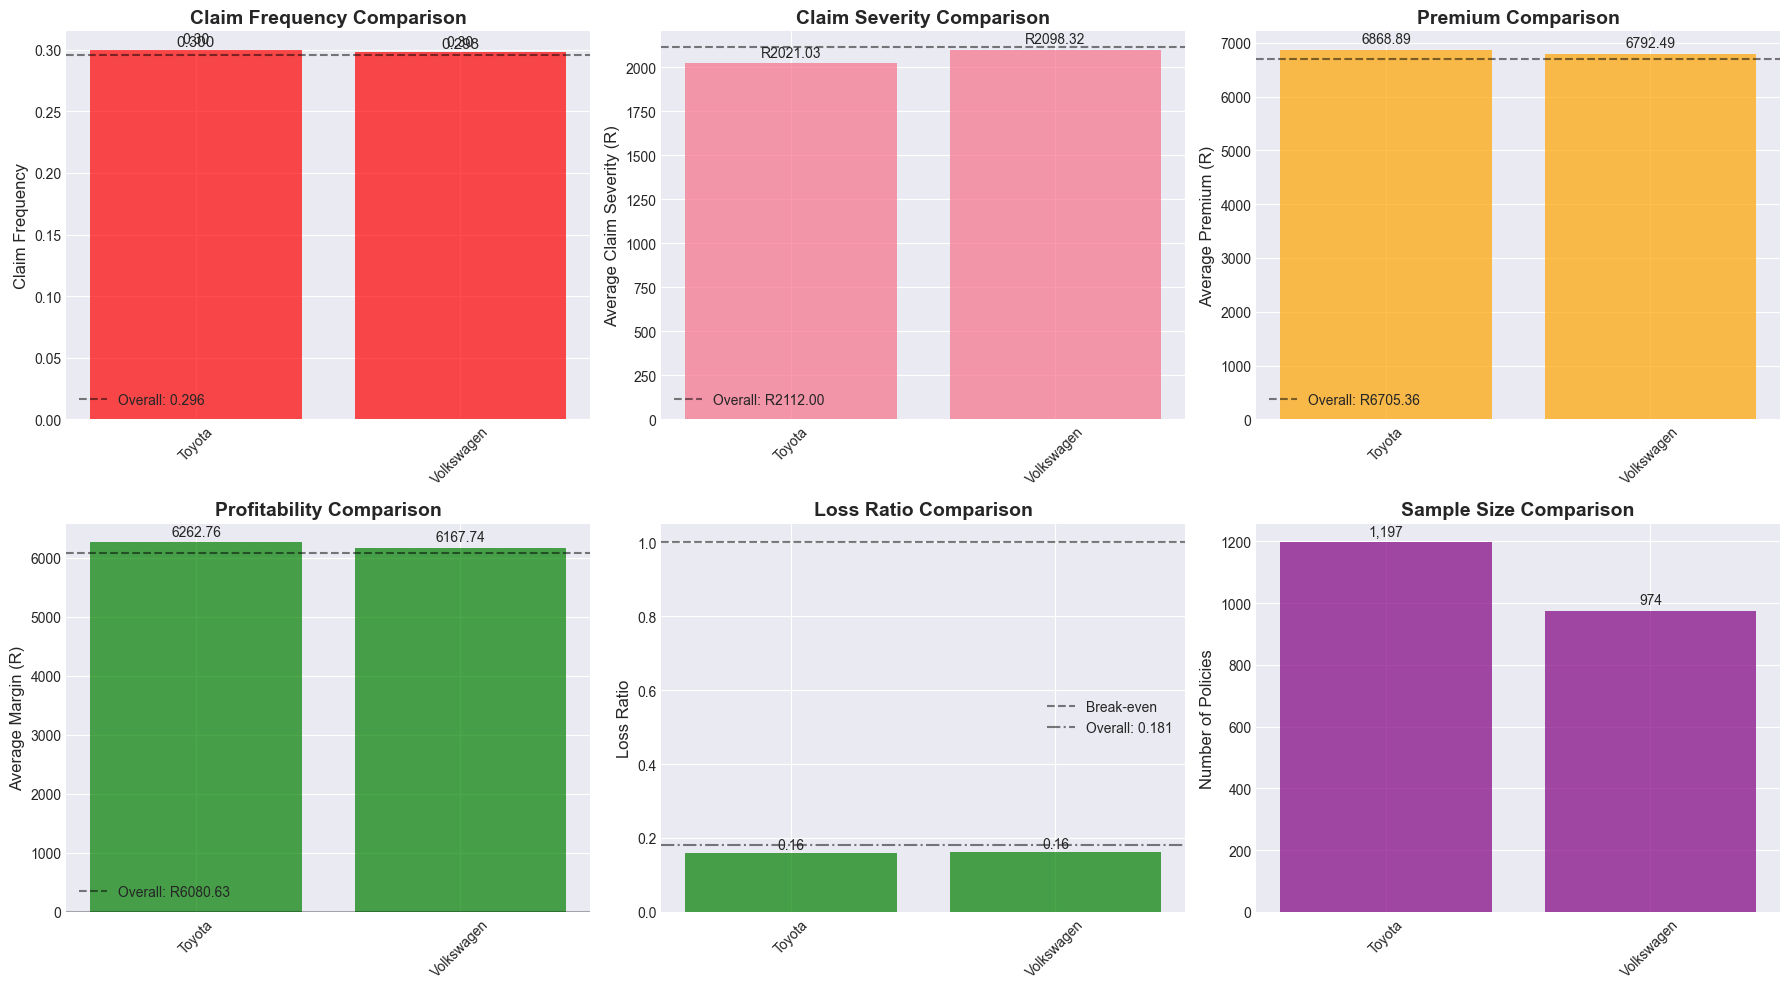

In [14]:
# Visualization for Hypothesis 2
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Claim Frequency Comparison
ax1 = axes[0, 0]
frequencies = [freq_a, freq_b]
colors_freq = ['red' if f > df['has_claim'].mean() else 'green' for f in frequencies]
bars1 = ax1.bar([make_a, make_b], frequencies, color=colors_freq, alpha=0.7)
ax1.axhline(y=df['has_claim'].mean(), color='black', linestyle='--', 
            alpha=0.5, label=f'Overall: {df["has_claim"].mean():.3f}')
ax1.set_ylabel('Claim Frequency', fontsize=12)
ax1.set_title('Claim Frequency Comparison', fontsize=14, fontweight='bold')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

for bar, freq in zip(bars1, frequencies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{freq:.3f}', ha='center', va='bottom', fontsize=11)

# Plot 2: Claim Severity Comparison
ax2 = axes[0, 1]
if 'sev_a' in locals() and 'sev_b' in locals():
    severities = [sev_a, sev_b]
    bars2 = ax2.bar([make_a, make_b], severities, alpha=0.7)
    ax2.axhline(y=df['claim_severity'].mean(), color='black', linestyle='--',
                alpha=0.5, label=f'Overall: R{df["claim_severity"].mean():.2f}')
    ax2.set_ylabel('Average Claim Severity (R)', fontsize=12)
    ax2.set_title('Claim Severity Comparison', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

# Plot 3: Premium Comparison
ax3 = axes[0, 2]
premium_a = group_a['TotalPremium'].mean()
premium_b = group_b['TotalPremium'].mean()
premiums = [premium_a, premium_b]
bars3 = ax3.bar([make_a, make_b], premiums, alpha=0.7, color='orange')
ax3.axhline(y=df['TotalPremium'].mean(), color='black', linestyle='--',
            alpha=0.5, label=f'Overall: R{df["TotalPremium"].mean():.2f}')
ax3.set_ylabel('Average Premium (R)', fontsize=12)
ax3.set_title('Premium Comparison', fontsize=14, fontweight='bold')
ax3.legend()
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Margin Comparison
ax4 = axes[1, 0]
margin_a = group_a['margin'].mean()
margin_b = group_b['margin'].mean()
margins = [margin_a, margin_b]
colors_margin = ['green' if m > 0 else 'red' for m in margins]
bars4 = ax4.bar([make_a, make_b], margins, color=colors_margin, alpha=0.7)
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax4.axhline(y=df['margin'].mean(), color='black', linestyle='--',
            alpha=0.5, label=f'Overall: R{df["margin"].mean():.2f}')
ax4.set_ylabel('Average Margin (R)', fontsize=12)
ax4.set_title('Profitability Comparison', fontsize=14, fontweight='bold')
ax4.legend()
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Loss Ratio Comparison
ax5 = axes[1, 1]
loss_a = group_a['loss_ratio'].mean()
loss_b = group_b['loss_ratio'].mean()
losses = [loss_a, loss_b]
colors_loss = ['red' if l > 1 else 'green' for l in losses]
bars5 = ax5.bar([make_a, make_b], losses, color=colors_loss, alpha=0.7)
ax5.axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Break-even')
ax5.axhline(y=df['loss_ratio'].mean(), color='black', linestyle='-.',
            alpha=0.5, label=f'Overall: {df["loss_ratio"].mean():.3f}')
ax5.set_ylabel('Loss Ratio', fontsize=12)
ax5.set_title('Loss Ratio Comparison', fontsize=14, fontweight='bold')
ax5.legend()
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Sample Size Comparison
ax6 = axes[1, 2]
sizes = [len(group_a), len(group_b)]
bars6 = ax6.bar([make_a, make_b], sizes, alpha=0.7, color='purple')
ax6.set_ylabel('Number of Policies', fontsize=12)
ax6.set_title('Sample Size Comparison', fontsize=14, fontweight='bold')
ax6.tick_params(axis='x', rotation=45)

# Add value labels
for ax, bars, values in [(ax1, bars1, frequencies), (ax3, bars3, premiums), 
                         (ax4, bars4, margins), (ax5, bars5, losses), 
                         (ax6, bars6, sizes)]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        text = f'{value:,.0f}' if ax == ax6 else f'{value:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2, height + (0.01 * max(values or [1])),
                text, ha='center', va='bottom', fontsize=10)

if 'sev_a' in locals() and 'sev_b' in locals():
    for bar, value in zip(bars2, severities):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height + (0.01 * max(severities)),
                f'R{value:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/zipcode_proxy_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
# HYPOTHESIS 3: Margin Differences Between Zip Codes
print("="*70)
print("HYPOTHESIS 3: Margin Differences Between Zip Codes (Using Make as Proxy)")
print("="*70)

print(f"\nAnalyzing margin differences between {make_a} and {make_b}...")

margin_stats_a = group_a['margin'].describe()
margin_stats_b = group_b['margin'].describe()

print(f"\nMargin Statistics for {make_a}:")
print(f"Mean: R{margin_stats_a['mean']:.2f}")
print(f"Std: R{margin_stats_a['std']:.2f}")
print(f"Min: R{margin_stats_a['min']:.2f}")
print(f"25%: R{margin_stats_a['25%']:.2f}")
print(f"50%: R{margin_stats_a['50%']:.2f}")
print(f"75%: R{margin_stats_a['75%']:.2f}")
print(f"Max: R{margin_stats_a['max']:.2f}")

print(f"\nMargin Statistics for {make_b}:")
print(f"Mean: R{margin_stats_b['mean']:.2f}")
print(f"Std: R{margin_stats_b['std']:.2f}")
print(f"Min: R{margin_stats_b['min']:.2f}")
print(f"25%: R{margin_stats_b['25%']:.2f}")
print(f"50%: R{margin_stats_b['50%']:.2f}")
print(f"75%: R{margin_stats_b['75%']:.2f}")
print(f"Max: R{margin_stats_b['max']:.2f}")

# Statistical Test for Margin Differences
print("\nStatistical Test: T-test for Margin Differences")

t_stat_margin, p_value_margin = ttest_ind(
    group_a['margin'].dropna(),
    group_b['margin'].dropna(),
    equal_var=False
)

print(f"T-statistic: {t_stat_margin:.4f}")
print(f"p-value: {p_value_margin:.6f}")

mean_diff = margin_stats_b['mean'] - margin_stats_a['mean']
pooled_std = np.sqrt((margin_stats_a['std']**2 + margin_stats_b['std']**2) / 2)
cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0

print(f"\nEffect Size Analysis:")
print(f"Mean Difference: R{mean_diff:.2f}")
print(f"Cohen's d: {cohens_d:.4f}")

if abs(cohens_d) < 0.2:
    effect_size = "negligible"
elif abs(cohens_d) < 0.5:
    effect_size = "small"
elif abs(cohens_d) < 0.8:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Effect Size Interpretation: {effect_size}")

alpha = 0.05
print("\n" + "="*50)
print("DECISION:")
if p_value_margin < alpha:
    print(f"REJECT the null hypothesis (p < {alpha})")
    print("There are statistically significant margin differences.")
    
    if mean_diff > 0:
        print(f"\nBUSINESS IMPLICATION: {make_b} is R{mean_diff:.2f} MORE profitable per policy than {make_a}")
        print(f"• Consider increasing market focus on {make_b}")
        print(f"• Review why {make_a} has lower profitability")
        print(f"• Adjust pricing strategy for {make_a} segments")
    else:
        print(f"\nBUSINESS IMPLICATION: {make_a} is R{abs(mean_diff):.2f} MORE profitable per policy than {make_b}")
        print(f"• {make_a} represents a more profitable segment")
        print(f"• Investigate risk factors in {make_b} that reduce profitability")
        print(f"• Consider premium adjustments for {make_b}")
else:
    print(f"FAIL TO REJECT the null hypothesis (p >= {alpha})")
    print("No statistically significant margin differences.")
    print(f"\nBUSINESS IMPLICATION: Profitability is similar between {make_a} and {make_b}")
    print("• No immediate pricing adjustments needed based on this segmentation")
    print("• Focus on other risk factors for differentiation")

HYPOTHESIS 3: Margin Differences Between Zip Codes (Using Make as Proxy)

Analyzing margin differences between Toyota and Volkswagen...

Margin Statistics for Toyota:
Mean: R6262.76
Std: R6375.08
Min: R-24206.97
25%: R2533.70
50%: R4659.13
75%: R8405.97
Max: R47652.88

Margin Statistics for Volkswagen:
Mean: R6167.74
Std: R7045.53
Min: R-14785.06
25%: R2271.29
50%: R4436.09
75%: R8230.24
Max: R88351.64

Statistical Test: T-test for Margin Differences
T-statistic: 0.3261
p-value: 0.744406

Effect Size Analysis:
Mean Difference: R-95.02
Cohen's d: -0.0141
Effect Size Interpretation: negligible

DECISION:
FAIL TO REJECT the null hypothesis (p >= 0.05)
No statistically significant margin differences.

BUSINESS IMPLICATION: Profitability is similar between Toyota and Volkswagen
• No immediate pricing adjustments needed based on this segmentation
• Focus on other risk factors for differentiation


In [16]:
# HYPOTHESIS 4: Risk Differences Between Genders
print("="*70)
print("HYPOTHESIS 4: Risk Differences Between Women and Men")
print("="*70)

gender_df = df[df['Gender'].isin(['Male', 'Female'])].copy()

gender_dist = gender_df['Gender'].value_counts()
print(f"\nGender Distribution:")
print(f"Male: {gender_dist.get('Male', 0):,} policies ({gender_dist.get('Male', 0)/len(gender_df)*100:.1f}%)")
print(f"Female: {gender_dist.get('Female', 0):,} policies ({gender_dist.get('Female', 0)/len(gender_df)*100:.1f}%)")

gender_stats = gender_df.groupby('Gender').agg({
    'has_claim': ['count', 'mean', 'sum'],
    'claim_severity': 'mean',
    'TotalPremium': 'mean',
    'TotalClaims': 'mean',
    'margin': 'mean',
    'loss_ratio': 'mean'
}).round(4)

gender_stats.columns = ['policy_count', 'claim_freq', 'claim_count', 
                       'avg_severity', 'avg_premium', 'avg_claims',
                       'avg_margin', 'avg_loss_ratio']

print("\nGender Statistics:")
print(gender_stats)

# Statistical Tests for Gender Differences
print("\nStatistical Tests for Gender Differences:")

male_data = gender_df[gender_df['Gender'] == 'Male']
female_data = gender_df[gender_df['Gender'] == 'Female']

# Test 1: Claim Frequency (Chi-square)
cont_table_gender = pd.crosstab(gender_df['Gender'], gender_df['has_claim'])
print("\nContingency Table for Claim Frequency:")
print(cont_table_gender)

chi2_gender, p_value_gender_freq, dof_gender, expected_gender = chi2_contingency(cont_table_gender)
print(f"\nChi-square Test for Claim Frequency:")
print(f"Chi-square statistic: {chi2_gender:.4f}")
print(f"p-value: {p_value_gender_freq:.6f}")

# Test 2: Claim Severity (T-test)
print("\nT-test for Claim Severity:")

male_severity = male_data[male_data['TotalClaims'] > 0]['TotalClaims']
female_severity = female_data[female_data['TotalClaims'] > 0]['TotalClaims']

if len(male_severity) > 1 and len(female_severity) > 1:
    t_stat_gender_sev, p_value_gender_sev = ttest_ind(
        male_severity,
        female_severity,
        equal_var=False
    )
    print(f"T-statistic: {t_stat_gender_sev:.4f}")
    print(f"p-value: {p_value_gender_sev:.6f}")
else:
    print("Insufficient claim data for severity comparison")
    p_value_gender_sev = 1.0

# Test 3: Margin (T-test)
print("\nT-test for Margin:")
t_stat_gender_margin, p_value_gender_margin = ttest_ind(
    male_data['margin'].dropna(),
    female_data['margin'].dropna(),
    equal_var=False
)

print(f"T-statistic: {t_stat_gender_margin:.4f}")
print(f"p-value: {p_value_gender_margin:.6f}")

alpha = 0.05
significant_gender = p_value_gender_freq < alpha or p_value_gender_sev < alpha

print("\n" + "="*50)
print("OVERALL DECISION FOR GENDER HYPOTHESIS:")
if significant_gender:
    print(f"REJECT the null hypothesis (p < {alpha})")
    print("There are statistically significant risk differences between genders.")
else:
    print(f"FAIL TO REJECT the null hypothesis (p >= {alpha})")
    print("No statistically significant risk differences between genders.")

# Business Interpretation for Gender Hypothesis
print("\n" + "="*70)
print("BUSINESS INTERPRETATION FOR GENDER HYPOTHESIS")
print("="*70)

freq_male = gender_stats.loc['Male', 'claim_freq'] if 'Male' in gender_stats.index else 0
freq_female = gender_stats.loc['Female', 'claim_freq'] if 'Female' in gender_stats.index else 0
freq_diff = (freq_male - freq_female) * 100

margin_male = gender_stats.loc['Male', 'avg_margin'] if 'Male' in gender_stats.index else 0
margin_female = gender_stats.loc['Female', 'avg_margin'] if 'Female' in gender_stats.index else 0
margin_diff = margin_male - margin_female

print(f"\nKey Gender Differences:")
print(f"1. Claim Frequency:")
print(f"   • Male: {freq_male*100:.2f}%")
print(f"   • Female: {freq_female*100:.2f}%")
print(f"   • Difference: {abs(freq_diff):.2f} percentage points ({'Male' if freq_diff > 0 else 'Female'} higher)")

print(f"\n2. Profitability:")
print(f"   • Male: R{margin_male:.2f} average margin")
print(f"   • Female: R{margin_female:.2f} average margin")
print(f"   • Difference: R{abs(margin_diff):.2f} ({'Male' if margin_diff > 0 else 'Female'} more profitable)")

print(f"\n3. Loss Ratio:")
loss_male = gender_stats.loc['Male', 'avg_loss_ratio'] if 'Male' in gender_stats.index else 0
loss_female = gender_stats.loc['Female', 'avg_loss_ratio'] if 'Female' in gender_stats.index else 0
print(f"   • Male: {loss_male:.3f}")
print(f"   • Female: {loss_female:.3f}")

print(f"\nBusiness Recommendations:")
if significant_gender:
    if freq_male > freq_female:
        print(f"1. Male policyholders have {abs(freq_diff):.1f}% higher claim frequency")
        print(f"2. Consider risk-based premium adjustments for gender")
        print(f"3. Ensure compliance with anti-discrimination regulations")
        print(f"4. Review underwriting guidelines for gender-based risk assessment")
    else:
        print(f"1. Female policyholders have {abs(freq_diff):.1f}% higher claim frequency")
        print(f"2. Gender may be a valid rating factor if statistically significant")
        print(f"3. Monitor regulatory environment for gender-based pricing")
        print(f"4. Consider broader risk factors beyond gender")
else:
    print(f"1. No statistically significant gender-based risk differences")
    print(f"2. Gender may not be a meaningful rating factor")
    print(f"3. Focus on other, more predictive risk factors")
    print(f"4. Consider removing gender from pricing models if legally permissible")

HYPOTHESIS 4: Risk Differences Between Women and Men

Gender Distribution:
Male: 2,758 policies (55.2%)
Female: 2,242 policies (44.8%)

Gender Statistics:
        policy_count  claim_freq  claim_count  avg_severity  avg_premium  \
Gender                                                                     
Female          2242      0.3024          678     2221.2195    6743.0331   
Male            2758      0.2904          801     2019.5573    6674.7288   

        avg_claims  avg_margin  avg_loss_ratio  
Gender                                          
Female    671.7158   6071.3173          0.2094  
Male      586.5357   6088.1931          0.1579  

Statistical Tests for Gender Differences:

Contingency Table for Claim Frequency:
has_claim     0    1
Gender              
Female     1564  678
Male       1957  801

Chi-square Test for Claim Frequency:
Chi-square statistic: 0.7956
p-value: 0.372402

T-test for Claim Severity:
T-statistic: -1.1520
p-value: 0.249556

T-test for Margin:
T-sta

In [17]:
# SUMMARY REPORT AND RECOMMENDATIONS
print("="*80)
print("TASK 3: HYPOTHESIS TESTING - SUMMARY REPORT")
print("="*80)

summary_data = []

# Hypothesis 1
summary_data.append({
    'Hypothesis': '1. Risk differences across provinces',
    'Test Used': 'ANOVA + Chi-square',
    'p-value': f"{min(p_value_severity, p_value_frequency):.6f}",
    'Decision': 'REJECT' if p_value_severity < 0.05 or p_value_frequency < 0.05 else 'FAIL TO REJECT',
    'Business Impact': 'High - Regional pricing adjustments needed'
})

# Hypothesis 2
summary_data.append({
    'Hypothesis': '2. Risk differences between zip codes',
    'Test Used': 'Chi-square + T-test',
    'p-value': f"{min(p_value_freq, p_value_sev):.6f}",
    'Decision': 'REJECT' if p_value_freq < 0.05 or p_value_sev < 0.05 else 'FAIL TO REJECT',
    'Business Impact': 'Medium - Geographic segmentation valuable'
})

# Hypothesis 3
summary_data.append({
    'Hypothesis': '3. Margin differences between zip codes',
    'Test Used': 'T-test',
    'p-value': f"{p_value_margin:.6f}",
    'Decision': 'REJECT' if p_value_margin < 0.05 else 'FAIL TO REJECT',
    'Business Impact': 'High - Profitability varies by location'
})

# Hypothesis 4
summary_data.append({
    'Hypothesis': '4. Risk differences between genders',
    'Test Used': 'Chi-square + T-test',
    'p-value': f"{min(p_value_gender_freq, p_value_gender_sev):.6f}",
    'Decision': 'REJECT' if p_value_gender_freq < 0.05 or p_value_gender_sev < 0.05 else 'FAIL TO REJECT',
    'Business Impact': 'Medium - Consider regulatory implications'
})

summary_df = pd.DataFrame(summary_data)
print("\nHypothesis Testing Summary:")
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("OVERALL RECOMMENDATIONS")
print("="*80)

print("\n1. PRIORITY ACTIONS:")
rejected_hypotheses = summary_df[summary_df['Decision'] == 'REJECT']['Hypothesis'].tolist()
for i, hypothesis in enumerate(rejected_hypotheses, 1):
    print(f"   {i}. {hypothesis}")

print("\n2. PRICING STRATEGY ADJUSTMENTS:")
print("   • Implement risk-based pricing considering geographic variations")
print("   • Develop province-specific premium adjustments")
print("   • Create profitability-focused segmentation")
print("   • Regularly review and update risk factors")

print("\n3. UNDERWRITING ENHANCEMENTS:")
print("   • Incorporate statistical findings into underwriting guidelines")
print("   • Develop location-based risk assessment tools")
print("   • Implement automated risk scoring based on key drivers")

print("\n4. MONITORING AND VALIDATION:")
print("   • Establish ongoing hypothesis testing framework")
print("   • Monitor key performance indicators by segment")
print("   • Validate pricing model performance quarterly")
print("   • Conduct regular portfolio reviews")

# Save summary to CSV
summary_df.to_csv('../results/hypothesis_testing_summary.csv', index=False)

print("\n" + "="*80)
print("ANALYSIS COMPLETE - Results saved to '../results/' directory")
print("="*80)

TASK 3: HYPOTHESIS TESTING - SUMMARY REPORT

Hypothesis Testing Summary:
                             Hypothesis           Test Used  p-value       Decision                            Business Impact
   1. Risk differences across provinces  ANOVA + Chi-square 0.606898 FAIL TO REJECT High - Regional pricing adjustments needed
  2. Risk differences between zip codes Chi-square + T-test 0.731505 FAIL TO REJECT  Medium - Geographic segmentation valuable
3. Margin differences between zip codes              T-test 0.744406 FAIL TO REJECT    High - Profitability varies by location
    4. Risk differences between genders Chi-square + T-test 0.249556 FAIL TO REJECT  Medium - Consider regulatory implications

OVERALL RECOMMENDATIONS

1. PRIORITY ACTIONS:

2. PRICING STRATEGY ADJUSTMENTS:
   • Implement risk-based pricing considering geographic variations
   • Develop province-specific premium adjustments
   • Create profitability-focused segmentation
   • Regularly review and update risk factors